# This notebook plots the majority of the figures in the paper

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy
from scipy.stats import linregress
import matplotlib
import bluepysnap as bp
from scipy import signal

In [2]:
%matplotlib widget

In [3]:
plt.rcParams.update({'font.size': 12})

### The following cells define the paths to the different simulation campaigns

In [4]:
# Defines paths to the simulation campaigns
s1 = 'original/fixed/a9f782a3-1f22-4384-a122-430bc6b2323c'
s2 = 'rewired/97d6aa07-db02-48c6-91c2-b3023ce5bdd0'

s8 = 'disconnected/fixed/noNoise/noL4Inh/871c007b-face-4656-b883-eed949ffbc92'

s9 = 'disconnected/fixed/noNoise/noL5Inh/c2ba9f02-6a83-426f-a77f-fa766cd97e1b'

s10 = 'disconnected/fixed/noNoise/noL6Inh/8bc7ca1f-45c8-47a2-a656-17e86bc2b384'

s11 = 'disconnected/fixed/noNoise/noL23Inh/da78079e-3792-4ebd-a57b-f72ccd3fde11'
s12 = 'disconnected/fixed/noNoise/noL23Exc/5bed2b84-e59a-4925-8556-d8c8a4815448'

s13 = 'disconnected/fixed/noNoise/noL4Exc/d2632df2-f8f4-469d-bbe5-25c794668551'
s14 = 'disconnected/fixed/noNoise/noL5Exc/18ecf6a9-eae2-463e-a272-002907a40f07'
s15 = 'disconnected/fixed/noNoise/noL6Exc/c9476d38-4af9-45a6-b1cf-77f3528f5b56'

s17 = 'rewired/disconnected/noNoise/noL23Exc/d6d80bd8-f3ec-4f9c-a142-24d475412346'
s18 = 'rewired/disconnected/noNoise/noL23Inh/7a688cef-aaec-4007-96ad-e9816549ed19'
s19 = 'rewired/disconnected/noNoise/noL4Exc/6dbad045-83ca-45de-88f7-ec17e17c5dc3'
s20 = 'rewired/disconnected/noNoise/noL4Inh/22249d06-3572-414c-a0aa-98828e1845ac'
s21 = 'rewired/disconnected/noNoise/noL5Exc/293e98bf-8010-4ab2-9fd0-352989d62a8a'
s22 = 'rewired/disconnected/noNoise/noL5Inh/e21b5a4e-e45b-4346-bd59-62f825b5b791'
s23 = 'rewired/disconnected/noNoise/noL6Exc/032c2685-dc15-4f0d-a577-839673df0543'
s24 = 'rewired/disconnected/noNoise/noL6Inh/5494e691-2a56-4228-aeaa-79fe165001e1'

s26 = 'rewired/disconnected/noNoise/noL5LBC/088f41b4-dbe4-4613-aff2-378ebca9d77c'
s27 = 'rewired/disconnected/noNoise/noL5NBC/7bd2120f-64a1-4c33-8824-83cc7c03a974'

s29 = 'disconnected/fixed/noNoise/noL5LBC/2d45c3db-8c1a-4bd9-a425-567d1dd0e22e'
s30 = 'disconnected/fixed/noNoise/noL5NBC/6176915e-1996-4761-9002-86e5ba2a97dc'



In [5]:
s31 = 'rewired/disconnected/noL1Inh/56add26b-6318-445b-b83e-f8461c9314ed'
s30 = 'disconnected/fixed/noNoise/noL1Inh/9508592e-7855-4acb-9f7e-c3f276ec6500'
s32 = 'rewired/testReference/94fc0a48-b6c2-4d0f-a659-4c9aab03dd01/'


In [10]:
sC = 'rewired/disconnected/compressedTime/e56c337b-eeed-4a10-b584-03edb277421a'


In [11]:
sT = 'disconnected/noThalamus/7f42ec58-030d-4a17-8cb0-d2c36616221a'
sTr = 'rewired/disconnected/noThalamus/7a9152d8-7fe1-41d3-9fea-703fe7b01f80'


### The following cells define functions used to load the EEG signals

In [18]:
time = np.linspace(-25,200,22000-19750)

In [19]:
def meanAndCI(EEGs):

    '''
    Given a matrix of EEG or spike histograms for each trial, finds the mean and 95% CI over trials
    '''

    mean = np.mean(EEGs,axis=0)

    lowerbound = scipy.stats.t.ppf(0.05,9,mean,np.std(EEGs,axis=0))
    upperbound = scipy.stats.t.ppf(0.95,9,mean,np.std(EEGs,axis=0))

    return mean, lowerbound, upperbound

In [20]:
def getEEGsByTypes(path):

    '''
    Given a path ot a simulation, creates a dictionary of EEG signals for each cell type
    '''

    EEGs = {}

    for file in os.listdir(path+'/pkls'):
        t = file.split('.')[0].split('g')[1]

        p = pd.read_pickle(path+'/pkls/'+file).values

        sos =  signal.butter(2,[1,500],btype='bandpass',output='sos',fs=10000)

        p1 = signal.sosfilt(sos,p,axis=0)
        
        EEGs[t] = p1[19750:22000,0] # # For memory reasons, we extract only a portion of the signal

    return EEGs

In [21]:
def getEEGByLayer(path_to_sims):

    '''
    Iterates over all trials, and produces a matrix of the EEG contributions of each layer, for excitatory and inhibitory cells separately
    Outputs a matrix of size nTrials x 2 x nLayers x nTimeSteps
    '''

    duration = 22000-19750

    allEEGList = []

    numSuccess = 0

    for sim in range(10):

        # try:

        s = bp.Simulation( path_to_sims +'/'+str(sim) + '/simulation_config.json' )
        c = s.circuit
        
    
        eegEXC = np.zeros((7,duration))
        eegINH = np.zeros((7,duration))
    
        eegList = [eegEXC, eegINH]

        EEGsByTypes = getEEGsByTypes(path_to_sims +'/'+str(sim))

        if EEGsByTypes == {}:
            continue
        else:
            numSuccess += 1
    
        for mtype in np.sort(np.unique(list(EEGsByTypes.keys()))):
    
            synsDF = list(c.nodes.get(group=mtype,properties=['synapse_class']))[0][1].loc['S1nonbarrel_neurons'].iloc[0].values
    
            if synsDF=='EXC':
                synIdx = 0
            elif synsDF=='INH':
                synIdx = 1
    
            layer = int(mtype.split('_')[0].split('L')[1])
    
            if layer == 2 or layer == 3 or layer == 23:
                layer = 2
    
            eegList[synIdx][layer] += (EEGsByTypes[mtype]-np.mean(EEGsByTypes[mtype][:250])) # Removes baseline offset

        allEEGList.append(eegList)        
    
    return np.array(allEEGList)

In [22]:
def getEEGs(path):

    '''
    Given a path to simulations, outputs the EEG from each trial
    Outputs a matrix of size nTrials x nTimeSteps
    '''

    EEGs = list(np.zeros(10))

    for i in range(10):

        for file in os.listdir(path+'/'+str(i)+'/pkls'):

            EEGs[i] += pd.read_pickle(path+'/'+str(i)+'/pkls/'+file).values[19750:22000,0] # For memory reasons, we extract only a portion of the signal

    
    EEGs = np.array(EEGs)
    EEGs -= np.mean(EEGs[:,:250],axis=-1)[:,np.newaxis] # Removes baseline offset

    return EEGs

In [23]:
def getStuff(path):

    EEGs = getEEGs(path)
    mean, lowerbound, upperbound = meanAndCI(EEGs)

    return mean, lowerbound, upperbound

In [24]:
def getByLayer(path):

    EEGs = np.array(getEEGByLayer(path))
    mean, lowerbound, upperbound = meanAndCI(EEGs)

    return mean, lowerbound, upperbound 

### The following cells load the EEG signals from the different simulation campaigns

In [26]:
mean_layer_original, _, _= getByLayer(s1)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [27]:
mean_layer_compressed, _, _= getByLayer(sC)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [29]:
mean_layer_disconnected_noThal, _, _ = getByLayer(sT)


/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [30]:
mean_layer_disconnected_noThalR, _, _ = getByLayer(sTr)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [31]:

mean_layer_rewired, _, _= getByLayer(s2)


/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [34]:
mean_layer_rewired_reference, _, _= getByLayer(s32)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [38]:

# mean_layer_rewiredDS, lowerbound_layer_rewiredDS, upperbound_layer_rewiredDS = getByLayer(s7)

mean_layer_L4, _, _ = getByLayer(s8)
mean_layer_L5, _, _ = getByLayer(s9)
mean_layer_L6, _, _ = getByLayer(s10)

mean_layer_L23Inh, _, _ = getByLayer(s11)
mean_layer_L23Exc, _, _ = getByLayer(s12)

mean_layer_L4Exc, _, _ = getByLayer(s13)
mean_layer_L5Exc, _, _ = getByLayer(s14)
mean_layer_L6Exc, _, _ = getByLayer(s15)



/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered 

In [39]:
mean_layer_L23ExcD, _,_ = getByLayer(s17)
mean_layer_L23InhD, _,_ = getByLayer(s18)
mean_layer_L4ExcD, _,_ = getByLayer(s19)
mean_layer_L4InhD, _,_ = getByLayer(s20)
mean_layer_L5ExcD, _,_ = getByLayer(s21)
mean_layer_L5InhD, _,_ = getByLayer(s22)
mean_layer_L6ExcD, _,_ = getByLayer(s23)
mean_layer_L6InhD, _,_ = getByLayer(s24)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered 

In [40]:

D_LBC, _,_ = getByLayer(s29)
D_NBC, _,_ = getByLayer(s30)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered 

In [41]:
rewired_NBC, _,_ = getByLayer(s27)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [42]:
rewired_LBC, _,_ = getByLayer(s26)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [43]:
mean_layer_L1Inh, _,_ = getByLayer(s30)
mean_layer_L1InhD, _,_ = getByLayer(s31)


/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


### The next cell defines a function used to calculate the FWHM of an EEG

In [119]:
def FWHM(signal, time = None):

    if time is None:
        time = np.linspace(-25,200,22000-19750)
    else:
        from scipy.interpolate import interp1d
        fcn = interp1d(time,signal,bounds_error=False,fill_value=0)
        time = np.linspace(-25,200,22000-19750)
        signal = fcn(time)

    minpoint = np.argmin(signal)

    minimum = np.min(signal)
    peak = np.argmax(signal)

    if peak > minpoint:
        peak = 0

    firstPoint = np.argmin(np.abs(signal[peak:minpoint]-minimum/2))+peak

    secondPoint = np.argmin(np.abs(signal[minpoint:]-minimum/2))+minpoint

    return time[secondPoint] - time[firstPoint]

### The following cells load and rescale the in vivo data

In [51]:
inVivo = np.genfromtxt('invivoData/EEG_InVivo.csv',delimiter=',')

In [52]:
inVivo13 = np.genfromtxt('invivoData/EEG_inVivo_P13.csv',delimiter=',')

In [53]:
inVivo21 = np.genfromtxt('invivoData/EEG_inVivo_P21.csv',delimiter=',')

In [128]:
inVivo10 = np.genfromtxt('invivoData/EEG_InVivo_P10.csv',delimiter=',')

In [54]:
inVivoY = inVivo[:,1]/np.max((inVivo[:,1]))*np.max((np.sum(mean_layer_original[0],axis=0)))


### The following cells calculate the contribution to the SEP from the different presynaptic populations

In [55]:
L1Inh = mean_layer_original - mean_layer_L1Inh

L23Exc = mean_layer_original - mean_layer_L23Exc
L4Exc = mean_layer_original - mean_layer_L4Exc
L5Exc = mean_layer_original - mean_layer_L5Exc
L6Exc = mean_layer_original - mean_layer_L6Exc

L23Inh = mean_layer_original - mean_layer_L23Inh
L4Inh = mean_layer_original - mean_layer_L4
L5Inh = mean_layer_original - mean_layer_L5
L6Inh = mean_layer_original - mean_layer_L6

In [56]:
L1InhD = mean_layer_rewired - mean_layer_L1InhD

L23ExcD = mean_layer_rewired - mean_layer_L23ExcD
L4ExcD = mean_layer_rewired - mean_layer_L4ExcD
L5ExcD = mean_layer_rewired - mean_layer_L5ExcD
L6ExcD = mean_layer_rewired - mean_layer_L6ExcD

L23InhD = mean_layer_rewired - mean_layer_L23InhD
L4InhD = mean_layer_rewired - mean_layer_L4InhD
L5InhD = mean_layer_rewired - mean_layer_L5InhD
L6InhD = mean_layer_rewired - mean_layer_L6InhD


In [57]:
contrib_rewired_LBC = mean_layer_rewired-rewired_LBC
contrib_rewired_NBC = mean_layer_rewired-rewired_NBC

contrib_LBC = mean_layer_original-D_LBC
contrib_NBC = mean_layer_original-D_NBC

In [64]:
contrib_thal = mean_layer_original-mean_layer_disconnected_noThal
contrib_thalR = mean_layer_rewired-mean_layer_disconnected_noThalR

### The following cells load spike times from the simulations

#### This cell loads the spike times of PeriTC cells from the SM circuit

In [157]:
 numRewiredSims = 0

for i in range(10):
    
    sRewired = bp.Simulation(s2+'/'+str(i)+'/simulation_config.json')

    try:
        if i == 0:
            rewiredSpikes = sRewired.spikes.filter('L5_NBC').report
            rewiredSpikes = pd.concat((rewiredSpikes,sRewired.spikes.filter('L5_LBC').report),axis=0)
        else:
            rewiredSpikes = pd.concat((rewiredSpikes,sRewired.spikes.filter('L5_NBC').report),axis=0)
            rewiredSpikes = pd.concat((rewiredSpikes,sRewired.spikes.filter('L5_LBC').report),axis=0)

        numRewiredSims += 1

    except:
        pass


HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 0:
  #000: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 836 in H5Fopen(): unable to synchronously open file
    major: File accessibility
    minor: Unable to open file
  #001: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 796 in H5F__open_api_common(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #002: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3863 in H5VL_file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3675 in H5VL__file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #004: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLnative_file.c line 128 in H5VL__native_file_open(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #005: /opt/hdf5-static/CMak

#### This cell loads the spike times of L5PCs cells from the SM circuit

In [141]:
 numRewiredSims = 0

for i in range(10):
    
    sRewired = bp.Simulation(s2+'/'+str(i)+'/simulation_config.json')

    try:
        if i == 0:
            rewiredSpikesPC = sRewired.spikes.filter('L5_TPC:A').report
            rewiredSpikesPC = pd.concat((rewiredSpikesPC,sRewired.spikes.filter('L5_TPC:B').report),axis=0)
            rewiredSpikesPC = pd.concat((rewiredSpikesPC,sRewired.spikes.filter('L5_TPC:C').report),axis=0)
            rewiredSpikesPC = pd.concat((rewiredSpikesPC,sRewired.spikes.filter('L5_UPC').report),axis=0)
        else:
            rewiredSpikesPC= pd.concat((rewiredSpikesPC,sRewired.spikes.filter('L5_TPC:A').report),axis=0)
            rewiredSpikesPC = pd.concat((rewiredSpikesPC,sRewired.spikes.filter('L5_TPC:B').report),axis=0)
            rewiredSpikesPC = pd.concat((rewiredSpikesPC,sRewired.spikes.filter('L5_TPC:C').report),axis=0)
            rewiredSpikesPC = pd.concat((rewiredSpikesPC,sRewired.spikes.filter('L5_UPC').report),axis=0)

        numRewiredSims += 1

    except:
        pass

HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 0:
  #000: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 836 in H5Fopen(): unable to synchronously open file
    major: File accessibility
    minor: Unable to open file
  #001: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 796 in H5F__open_api_common(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #002: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3863 in H5VL_file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3675 in H5VL__file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #004: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLnative_file.c line 128 in H5VL__native_file_open(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #005: /opt/hdf5-static/CMak

#### This cell loads the spike times of L23PCs cells from the SM circuit

In [ ]:
 numRewiredSims = 0

for i in range(10):
    
    sRewired = bp.Simulation(s2+'/'+str(i)+'/simulation_config.json')

    try:
        if i == 0:
            rewiredSpikes23PC = sRewired.spikes.filter('L2_TPC:A').report
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L2_TPC:B').report),axis=0)
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L2_IPC').report),axis=0)
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L3_TPC:A').report),axis=0)
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L3_TPC:C').report),axis=0)
        else:
            rewiredSpikes23PC= pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L2_TPC:A').report),axis=0)
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L2_TPC:B').report),axis=0)
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L2_IPC').report),axis=0)
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L3_TPC:A').report),axis=0)
            rewiredSpikes23PC = pd.concat((rewiredSpikes23PC,sRewired.spikes.filter('L3_TPC:C').report),axis=0)

        numRewiredSims += 1

    except:
        pass

#### This cell loads the spike times of L5Inh cells from the SM circuit

In [144]:
 numRewiredSims = 0

for i in range(10):
    
    sRewired = bp.Simulation(s2+'/'+str(i)+'/simulation_config.json')

    try:
        if i == 0:
            rewiredSpikesInh5 = sRewired.spikes.filter('Layer5Inhibitory').report

        else:
            rewiredSpikesInh5 = pd.concat((rewiredSpikesInh5,sRewired.spikes.filter('Layer5Inhibitory').report),axis=0)


        numRewiredSims += 1

    except:
        pass

HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 0:
  #000: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 836 in H5Fopen(): unable to synchronously open file
    major: File accessibility
    minor: Unable to open file
  #001: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 796 in H5F__open_api_common(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #002: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3863 in H5VL_file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3675 in H5VL__file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #004: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLnative_file.c line 128 in H5VL__native_file_open(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #005: /opt/hdf5-static/CMak

#### This cell loads the spike times of L6Inh cells from the SM circuit

In [145]:
 numRewiredSims = 0

for i in range(10):
    
    sRewired = bp.Simulation(s2+'/'+str(i)+'/simulation_config.json')

    try:
        if i == 0:
            rewiredSpikesInh6 = sRewired.spikes.filter('Layer6Inhibitory').report

        else:
            rewiredSpikesInh6 = pd.concat((rewiredSpikesInh5,sRewired.spikes.filter('Layer6Inhibitory').report),axis=0)


        numRewiredSims += 1

    except:
        pass

HDF5-DIAG: Error detected in HDF5 (1.14.3) thread 0:
  #000: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 836 in H5Fopen(): unable to synchronously open file
    major: File accessibility
    minor: Unable to open file
  #001: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5F.c line 796 in H5F__open_api_common(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #002: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3863 in H5VL_file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLcallback.c line 3675 in H5VL__file_open(): open failed
    major: Virtual Object Layer
    minor: Can't open object
  #004: /opt/hdf5-static/CMake-hdf5-1.14.3/hdf5-1.14.3/src/H5VLnative_file.c line 128 in H5VL__native_file_open(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #005: /opt/hdf5-static/CMak

#### This cell loads the spike times of PeriTC cells from the original circuit

In [156]:
for i in range(10):
    
    sOriginal = bp.Simulation(s1+'/'+str(i)+'/simulation_config.json')

    

    if i == 0:
        originalSpikes = sOriginal.spikes.filter('L5_NBC').report
        originalSpikes = pd.concat((originalSpikes,sOriginal.spikes.filter('L5_LBC').report),axis=0)
    else:
        originalSpikes = pd.concat((originalSpikes,sOriginal.spikes.filter('L5_NBC').report),axis=0)
        originalSpikes = pd.concat((originalSpikes,sOriginal.spikes.filter('L5_LBC').report),axis=0)

#### This cell loads the spike times of L5PCs cells from the original circuit

In [147]:
for i in range(10):
    
    sOriginal = bp.Simulation(s1+'/'+str(i)+'/simulation_config.json')

    

    if i == 0:
        originalSpikesPC = sOriginal.spikes.filter('L5_TPC:A').report
        originalSpikesPC = pd.concat((originalSpikesPC,sOriginal.spikes.filter('L5_TPC:B').report),axis=0)
        originalSpikesPC = pd.concat((originalSpikesPC,sOriginal.spikes.filter('L5_TPC:C').report),axis=0)
        originalSpikesPC = pd.concat((originalSpikesPC,sOriginal.spikes.filter('L5_UPC').report),axis=0)
    else:
        originalSpikesPC = pd.concat((originalSpikesPC,sOriginal.spikes.filter('L5_TPC:A').report),axis=0)
        originalSpikesPC = pd.concat((originalSpikesPC,sOriginal.spikes.filter('L5_TPC:B').report),axis=0)
        originalSpikesPC = pd.concat((originalSpikesPC,sOriginal.spikes.filter('L5_TPC:C').report),axis=0)
        originalSpikesPC = pd.concat((originalSpikesPC,sOriginal.spikes.filter('L5_UPC').report),axis=0)


#### This cell loads the spike times of L5PCs cells from the original circuit

In [ ]:
for i in range(10):
    
    sOriginal = bp.Simulation(s1+'/'+str(i)+'/simulation_config.json')

    if i == 0:
        originalSpikes23PC = sOriginal.spikes.filter('L2_TPC:A').report
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L2_TPC:B').report),axis=0)
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L2_IPC').report),axis=0)
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L3_TPC:A').report),axis=0)
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L3_TPC:C').report),axis=0)
    else:
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L2_TPC:A').report),axis=0)
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L2_TPC:B').report),axis=0)
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L2_IPC').report),axis=0)
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L3_TPC:A').report),axis=0)
        originalSpikes23PC = pd.concat((originalSpikes23PC,sOriginal.spikes.filter('L3_TPC:C').report),axis=0)

#### This cell loads the spike times of L5Inh cells from the original circuit

In [150]:
for i in range(10):
    
    sOriginal = bp.Simulation(s1+'/'+str(i)+'/simulation_config.json')

    

    if i == 0:
        originalSpikesInh5 = sOriginal.spikes.filter('Layer5Inhibitory').report
    else:
        originalSpikesInh5 = pd.concat((originalSpikesInh5,sOriginal.spikes.filter('Layer5Inhibitory').report),axis=0)


#### This cell loads the spike times of L6Inh cells from the original circuit

In [151]:
for i in range(10):
    
    sOriginal = bp.Simulation(s1+'/'+str(i)+'/simulation_config.json')

    

    if i == 0:
        originalSpikesInh6 = sOriginal.spikes.filter('Layer6Inhibitory').report
    else:
        originalSpikesInh6 = pd.concat((originalSpikesInh6,sOriginal.spikes.filter('Layer6Inhibitory').report),axis=0)

#### This cell loads the spike times of PeriTC cells from the disconnected circuit

In [159]:
for i in range(10):
    
    sDisconnected = bp.Simulation(s3+'/'+str(i)+'/simulation_config.json')

    if i == 0:
        disconnectedSpikes = sDisconnected.spikes.filter('L5_NBC').report
        disconnectedSpikes = pd.concat((disconnectedSpikes,sDisconnected.spikes.filter('L5_LBC').report),axis=0)
    else:
        disconnectedSpikes = pd.concat((disconnectedSpikes,sDisconnected.spikes.filter('L5_NBC').report),axis=0)
        disconnectedSpikes = pd.concat((disconnectedSpikes,sDisconnected.spikes.filter('L5_LBC').report),axis=0)

#### This cell defines the scaling factor

In [ ]:
scaleFactor = np.max(np.sum(mean_layer_original,axis=(0,1)))

# In the following cel, we produce Figrue 1f.
### Note that Figure 1g is identical to Figure 4a, which is produced later

In [ ]:
plt.figure(figsize=(8,2))

plt.subplot(1,4,1)
plt.plot(inVivo10[:,0], inVivo10[:,1]/scaleFactor,color='grey')
plt.xlim([0,200])
plt.ylim([-3,3])
plt.ylabel('Signal (au)')
plt.xlabel('Time (ms)')
plt.title('P10')

ax1 = plt.subplot(1,4,2)
plt.plot(inVivo13[:,0], inVivo13[:,1]/scaleFactor,color='grey')
plt.xlim([0,200])
plt.ylim([-3,3])
ax1.set_yticks([])
plt.xlabel('Time (ms)')
plt.title('P13')

ax2 = plt.subplot(1,4,3,sharey=ax1)
plt.plot(inVivo[:,0], inVivo[:,1]/scaleFactor,color='grey')
plt.ylim([-3,3])
plt.xlim([0,200])
ax2.set_yticks([])
plt.xlabel('Time (ms)')
plt.title('P16')

ax3 = plt.subplot(1,4,4,sharey=ax1)
plt.plot(inVivo21[:,0], inVivo21[:,1]/scaleFactor,color='grey')
plt.xlim([0,200])
plt.ylim([-3,3])
ax3.set_yticks([])
plt.xlabel('Time (ms)')
plt.title('P21')

plt.tight_layout()

plt.savefig('../../figures/digitization.png',dpi=600)

# In the following cells, we produce Figure 2

## The next cell produces Figure 2a.i

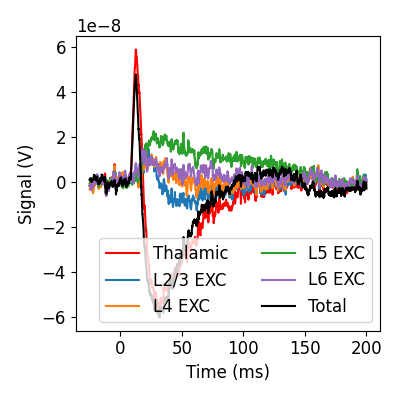

In [68]:
plt.figure(figsize=(4,4))


plt.plot(time,np.sum(contrib_thal[0]+contrib_thal[1],axis=0)/scaleFactor,'r')
plt.plot(time,np.sum(L23Exc[0]+L23Exc[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L4Exc[0]+L4Exc[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L5Exc[0]+L5Exc[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L6Exc[0]+L6Exc[1],axis=0)/scaleFactor,'tab:purple')


plt.plot(time,np.sum(mean_layer_original[0]+mean_layer_original[1],axis=0)/scaleFactor,'k')

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')

plt.legend(['Thalamic','L2/3 EXC','L4 EXC','L5 EXC','L6 EXC','Total'],ncol=2,loc='lower right')

plt.tight_layout()

plt.savefig('../../figures/CorticoCortical.png',dpi=600)



## The next cell produces Figure 2a.ii-v

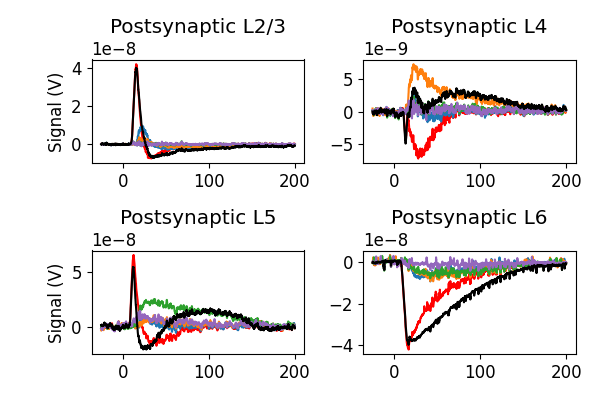

In [297]:
plt.figure(figsize=(6,4))
layers = [2,4,5,6]
for i, layer in enumerate(layers):
    plt.subplot(2,2,i+1)

    plt.plot(time,(contrib_thal[0,layer,:]+contrib_thal[1,layer,:])/scaleFactor,'r')
    plt.plot(time,(L23Exc[0,layer,:]+L23Exc[1,layer,:])/scaleFactor)
    
    plt.plot(time,(L4Exc[0,layer,:]+L4Exc[1,layer,:])/scaleFactor)
    plt.plot(time,(L5Exc[0,layer,:]+L5Exc[1,layer,:])/scaleFactor)
    plt.plot(time,(L6Exc[0,layer,:]+L6Exc[1,layer,:])/scaleFactor,'tab:purple')

    plt.plot(time,(mean_layer_original[0,layer,:]+mean_layer_original[1,layer,:])/scaleFactor,'k')


    if i%2 == 0:
        plt.ylabel('Signal (au)')

    if i == 0:
        title = 'Postsynaptic L2/3'
    else:
        title = 'Postsynaptic L'+str(layer)
    plt.title(title)

plt.tight_layout()
plt.savefig('../../figures/CorticoCorticalByLayer.png',dpi=600)

## This cell produces Figure 2b.i

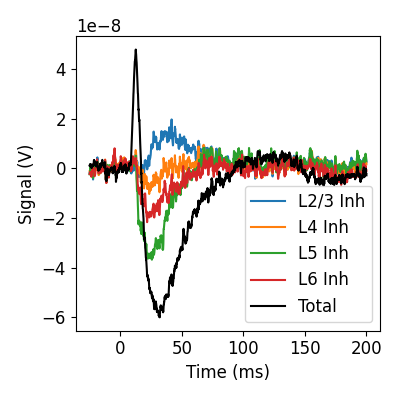

In [99]:
plt.figure(figsize=(4,4))

#plt.title('Cortico-cortical contribution by presnyaptic layer')

plt.plot(time,np.sum(L23Inh[0]+L23Inh[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L4Inh[0]+L4Inh[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L5Inh[0]+L5Inh[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L6Inh[0]+L6Inh[1],axis=0)/scaleFactor)


plt.plot(time,np.sum(mean_layer_original[0]+mean_layer_original[1],axis=0)/scaleFactor,'k')

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')

plt.legend(['L2/3 Inh','L4 Inh','L5 Inh','L6 Inh','Total'])

plt.tight_layout()
plt.savefig('../../figures/CorticoCorticalInh.png',dpi=600)



## This cell produces Figure 2b.ii-v

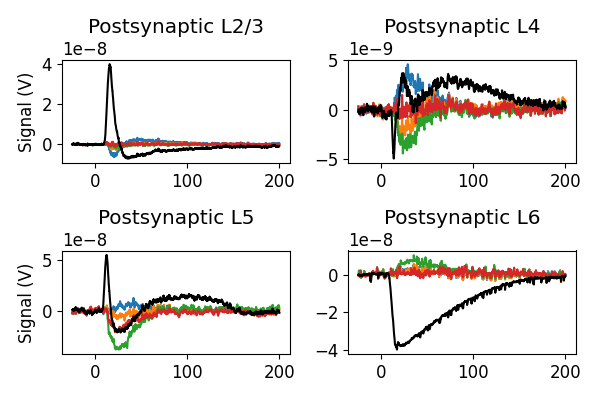

In [296]:
plt.figure(figsize=(6,4))
layers = [2,4,5,6]
for i, layer in enumerate(layers):
    plt.subplot(2,2,i+1)
    
    plt.plot(time,(L23Inh[0,layer,:]+L23Inh[1,layer,:])/scaleFactor)
    
    plt.plot(time,(L4Inh[0,layer,:]+L4Inh[1,layer,:])/scaleFactor)
    plt.plot(time,(L5Inh[0,layer,:]+L5Inh[1,layer,:])/scaleFactor)
    plt.plot(time,(L6Inh[0,layer,:]+L6Inh[1,layer,:])/scaleFactor)

    plt.plot(time,(mean_layer_original[0,layer,:]+mean_layer_original[1,layer,:])/scaleFactor,'k')



    if i%2 == 0:
        plt.ylabel('Signal (au)')
    
    if i == 0:
        title = 'Postsynaptic L2/3'
    else:
        title = 'Postsynaptic L'+str(layer)
    plt.title(title)

plt.tight_layout()
plt.savefig('../../figures/CorticoCorticalByLayerInh.png',dpi=600)
    

## This cell produces Figure 2c.i

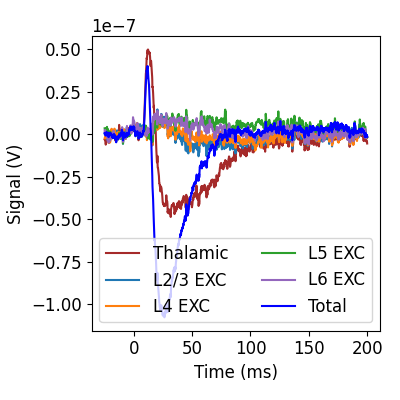

In [136]:
plt.figure(figsize=(4,4))


plt.plot(time,np.sum(contrib_thalR[0]+contrib_thalR[1],axis=0)/scaleFactor,'brown')
plt.plot(time,np.sum(L23ExcD[0]+L23ExcD[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L4ExcD[0]+L4ExcD[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L5ExcD[0]+L5ExcD[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L6ExcD[0]+L6ExcD[1],axis=0)/scaleFactor,'tab:purple')

plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor,'b')

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')

plt.legend(['Thalamic','L2/3 EXC','L4 EXC','L5 EXC','L6 EXC','Total'],ncols=2,loc='lower right')

plt.tight_layout()
plt.savefig('../../figures/CorticoCorticalRewired.png',dpi=600)

## This cell produces Figure 2c.ii-v

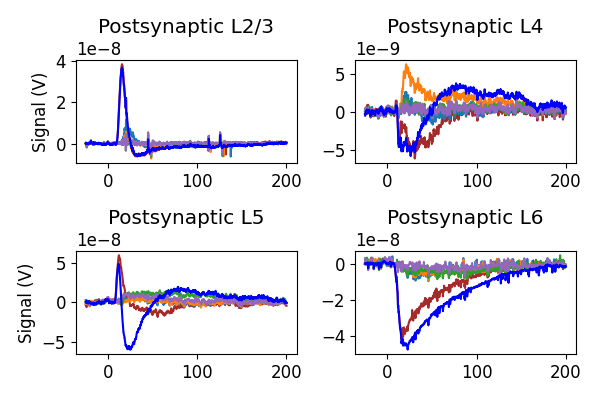

In [294]:
plt.figure(figsize=(6,4))
layers = [2,4,5,6]
for i, layer in enumerate(layers):
    plt.subplot(2,2,i+1)

    if i == 0:
        plt.title('Postsynaptic L2/3')
    else:
        plt.title('Postsynaptic L'+str(layer))

    plt.plot(time,(contrib_thalR[0,layer,:]+contrib_thalR[1,layer,:])/scaleFactor,'brown')
    
    plt.plot(time,(L23ExcD[0,layer,:]+L23ExcD[1,layer,:])/scaleFactor)
    
    plt.plot(time,(L4ExcD[0,layer,:]+L4ExcD[1,layer,:])/scaleFactor)
    plt.plot(time,(L5ExcD[0,layer,:]+L5ExcD[1,layer,:])/scaleFactor)
    plt.plot(time,(L6ExcD[0,layer,:]+L6ExcD[1,layer,:])/scaleFactor,'tab:purple')

    plt.plot(time,(mean_layer_rewired[0,layer,:]+mean_layer_rewired[1,layer,:])/scaleFactor,'b')

    if i % 2 == 0:
        plt.ylabel('Signal (au)')

plt.tight_layout()
plt.savefig('../../figures/CorticoCorticalRewiredByLayer.png',dpi=600)

## This cell produces Figure 2d.i

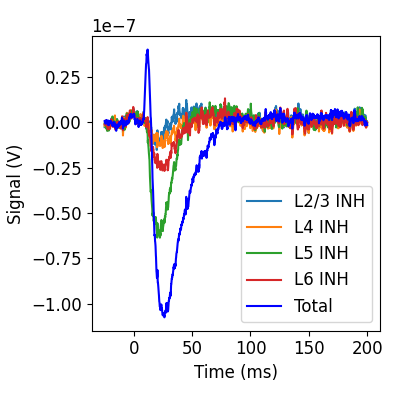

In [137]:
plt.figure(figsize=(4,4))


plt.plot(time,np.sum(L23InhD[0]+L23InhD[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L4InhD[0]+L4InhD[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L5InhD[0]+L5InhD[1],axis=0)/scaleFactor)
plt.plot(time,np.sum(L6InhD[0]+L6InhD[1],axis=0)/scaleFactor)

plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor,'b')

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')

plt.legend(['L2/3 INH','L4 INH','L5 INH','L6 INH','Total'])

plt.tight_layout()

plt.savefig('../../figures/CorticoCorticalRewiredInh.png',dpi=600)

## This cell produces Figure 2d.ii-v

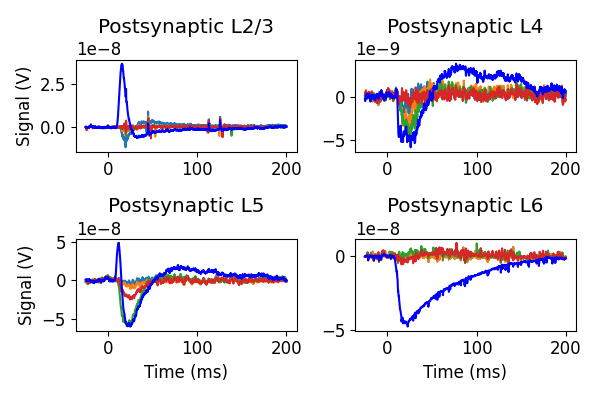

In [293]:
plt.figure(figsize=(6,4))
layers = [2,4,5,6]
for i, layer in enumerate(layers):
    plt.subplot(2,2,i+1)

    if i == 0:
        plt.title('Postsynaptic L2/3')
    else:
        plt.title('Postsynaptic L'+str(layer))
    
    plt.plot(time,(L23InhD[0,layer,:]+L23InhD[1,layer,:])/scaleFactor)
    
    plt.plot(time,(L4InhD[0,layer,:]+L4InhD[1,layer,:])/scaleFactor)
    plt.plot(time,(L5InhD[0,layer,:]+L5InhD[1,layer,:])/scaleFactor)
    plt.plot(time,(L6InhD[0,layer,:]+L6InhD[1,layer,:])/scaleFactor)

    plt.plot(time,(mean_layer_rewired[0,layer,:]+mean_layer_rewired[1,layer,:])/scaleFactor,'b')

    if i > 1:
        plt.xlabel('Time (ms)')
    if i % 2 == 0:
        plt.ylabel('Signal (au)')

plt.tight_layout()
plt.savefig('../../figures/CorticoCorticalRewiredInhByLayer.png',dpi=600)

## In the following cells, we produce the panels in Figure 2 showing the mean amplitudes attributable to different presynapic-postsynaptic pathways in the P1 an early N1 components

### The next cell defines the times for the P1 component and the early phase on the N1 component

In [69]:
tIdx0 = np.argmin(np.abs(time-8))
tIdx1 = np.argmin(np.abs(time-16))

tIdx2 = np.argmin(np.abs(time-40))



### The next cell produces Fig. 2a.vi-vii and 2b.vi-vi

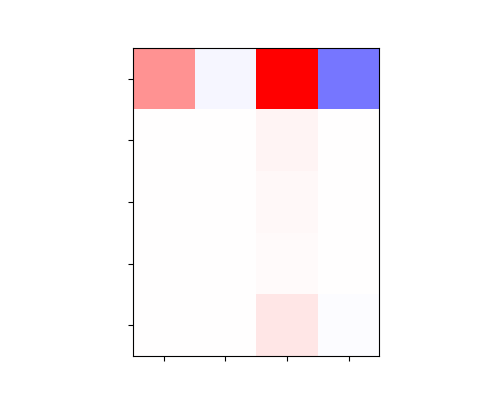

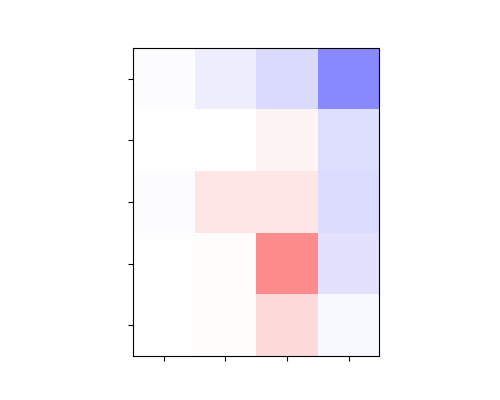

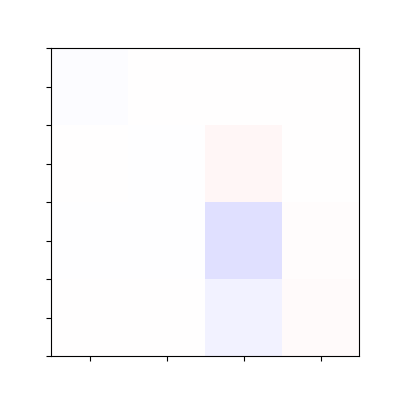

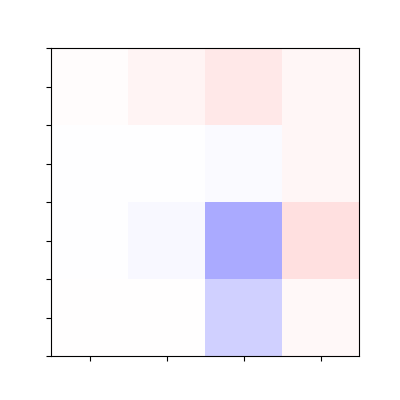

In [70]:
maxThal = np.mean(contrib_thal[0,:,tIdx0:tIdx1]+contrib_thal[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL23Exc = np.mean(L23Exc[0,:,tIdx0:tIdx1]+L23Exc[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL4Exc = np.mean(L4Exc[0,:,tIdx0:tIdx1]+L4Exc[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL5Exc = np.mean(L5Exc[0,:,tIdx0:tIdx1]+L5Exc[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL6Exc = np.mean(L6Exc[0,:,tIdx0:tIdx1]+L6Exc[1,:,tIdx0:tIdx1],axis=1)/scaleFactor

minThal = np.mean(contrib_thal[0,:,tIdx1:tIdx2]+contrib_thal[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL23Exc = np.mean(L23Exc[0,:,tIdx1:tIdx2]+L23Exc[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL4Exc = np.mean(L4Exc[0,:,tIdx1:tIdx2]+L4Exc[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL5Exc = np.mean(L5Exc[0,:,tIdx1:tIdx2]+L5Exc[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL6Exc = np.mean(L6Exc[0,:,tIdx1:tIdx2]+L6Exc[1,:,tIdx1:tIdx2],axis=1)/scaleFactor

maxL23Inh = np.mean(L23Inh[0,:,tIdx0:tIdx1]+L23Inh[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL4Inh = np.mean(L4Inh[0,:,tIdx0:tIdx1]+L4Inh[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL5Inh = np.mean(L5Inh[0,:,tIdx0:tIdx1]+L5Inh[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL6Inh = np.mean(L6Inh[0,:,tIdx0:tIdx1]+L6Inh[1,:,tIdx0:tIdx1],axis=1)/scaleFactor

minL23Inh = np.mean(L23Inh[0,:,tIdx1:tIdx2]+L23Inh[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL4Inh = np.mean(L4Inh[0,:,tIdx1:tIdx2]+L4Inh[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL5Inh = np.mean(L5Inh[0,:,tIdx1:tIdx2]+L5Inh[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL6Inh = np.mean(L6Inh[0,:,tIdx1:tIdx2]+L6Inh[1,:,tIdx1:tIdx2],axis=1)/scaleFactor

excMax = np.array([maxThal,maxL23Exc,maxL4Exc,maxL5Exc,maxL6Exc])[:,[2,4,5,6]]
excMin = np.array([minThal,minL23Exc,minL4Exc,minL5Exc,minL6Exc])[:,[2,4,5,6]]
inhMax = np.array([maxL23Inh,maxL4Inh,maxL5Inh,maxL6Inh])[:,[2,4,5,6]]
inhMin = np.array([minL23Inh,minL4Inh,minL5Inh,minL6Inh])[:,[2,4,5,6]]

plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(excMax,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('../../figures/originalMatrix_1.png',dpi=600)

plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(excMin,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('../../figures/originalMatrix_2.png',dpi=600)


plt.figure(figsize=(4,4))
ax = plt.gca()
plt.imshow(inhMax,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])
# plt.tight_layout()
plt.savefig('../../figures/originalMatrix_3.png',dpi=600)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.imshow(inhMin,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('../../figures/originalMatrix_4.png',dpi=600)

### The next cell produces Fig. 2c.vi-vii and 2d.vi-vi

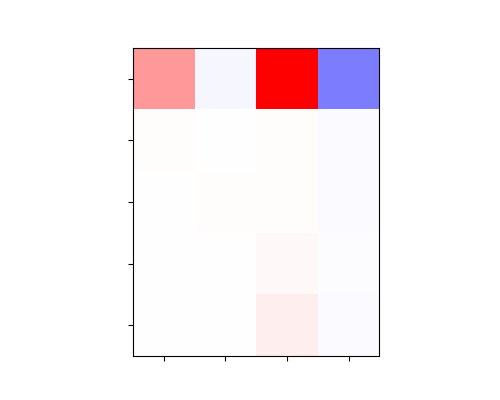

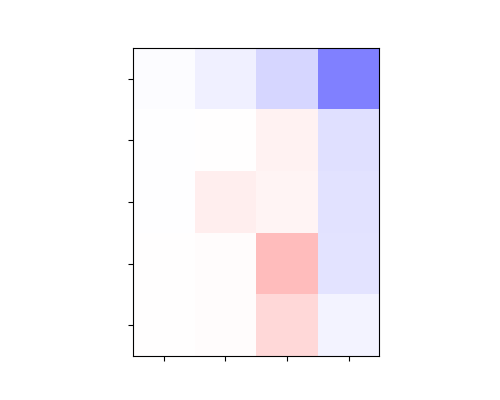

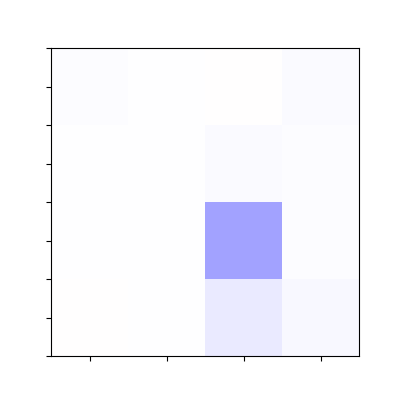

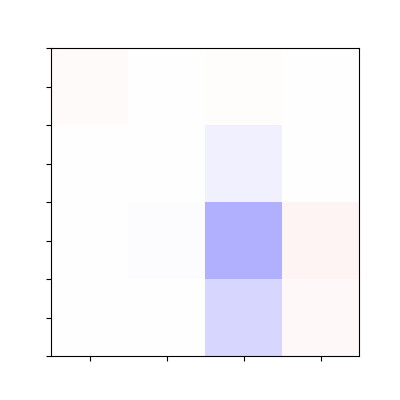

In [71]:
maxThal = np.mean(contrib_thalR[0,:,tIdx0:tIdx1]+contrib_thalR[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL23Exc = np.mean(L23ExcD[0,:,tIdx0:tIdx1]+L23ExcD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL4Exc = np.mean(L4ExcD[0,:,tIdx0:tIdx1]+L4ExcD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL5Exc = np.mean(L5ExcD[0,:,tIdx0:tIdx1]+L5ExcD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL6Exc = np.mean(L6ExcD[0,:,tIdx0:tIdx1]+L6ExcD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor

minThal = np.mean(contrib_thalR[0,:,tIdx1:tIdx2]+contrib_thalR[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL23Exc = np.mean(L23ExcD[0,:,tIdx1:tIdx2]+L23ExcD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL4Exc = np.mean(L4ExcD[0,:,tIdx1:tIdx2]+L4ExcD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL5Exc = np.mean(L5ExcD[0,:,tIdx1:tIdx2]+L5ExcD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL6Exc = np.mean(L6ExcD[0,:,tIdx1:tIdx2]+L6ExcD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor

maxL23Inh = np.mean(L23InhD[0,:,tIdx0:tIdx1]+L23InhD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL4Inh = np.mean(L4InhD[0,:,tIdx0:tIdx1]+L4InhD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL5Inh = np.mean(L5InhD[0,:,tIdx0:tIdx1]+L5InhD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor
maxL6Inh = np.mean(L6InhD[0,:,tIdx0:tIdx1]+L6InhD[1,:,tIdx0:tIdx1],axis=1)/scaleFactor

minL23Inh = np.mean(L23InhD[0,:,tIdx1:tIdx2]+L23InhD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL4Inh = np.mean(L4InhD[0,:,tIdx1:tIdx2]+L4InhD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL5Inh = np.mean(L5InhD[0,:,tIdx1:tIdx2]+L5InhD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor
minL6Inh = np.mean(L6InhD[0,:,tIdx1:tIdx2]+L6InhD[1,:,tIdx1:tIdx2],axis=1)/scaleFactor

excMaxD = np.array([maxThal,maxL23Exc,maxL4Exc,maxL5Exc,maxL6Exc])[:,[2,4,5,6]]
excMinD = np.array([minThal,minL23Exc,minL4Exc,minL5Exc,minL6Exc])[:,[2,4,5,6]]
inhMaxD = np.array([maxL23Inh,maxL4Inh,maxL5Inh,maxL6Inh])[:,[2,4,5,6]]
inhMinD = np.array([minL23Inh,minL4Inh,minL5Inh,minL6Inh])[:,[2,4,5,6]]

plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(excMaxD,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('../../figures/rewiredMatrix_1.png',dpi=600)

plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(excMinD,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('../../figures/rewiredMatrix_2.png',dpi=600)


plt.figure(figsize=(4,4))
ax = plt.gca()
plt.imshow(inhMaxD,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('../../figures/rewiredMatrix_3.png',dpi=600)

plt.figure(figsize=(4,4))
ax = plt.gca()
plt.imshow(inhMinD,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('../../figures/rewiredMatrix_4.png',dpi=600)

### This cell produces the color bar for the panels above

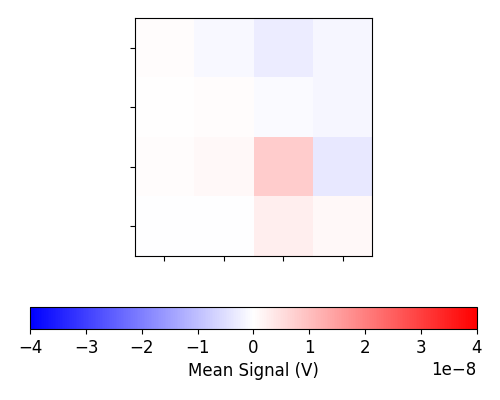

In [97]:
plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(inhMinD-inhMin,vmin=-4e-8/scaleFactor,vmax=4e-8/scaleFactor,cmap='bwr')
plt.colorbar(label = 'Mean Signal (au)', location='bottom')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('../../figures/matrixColorBar.png',dpi=600)

### The next cell produces Figure 2e

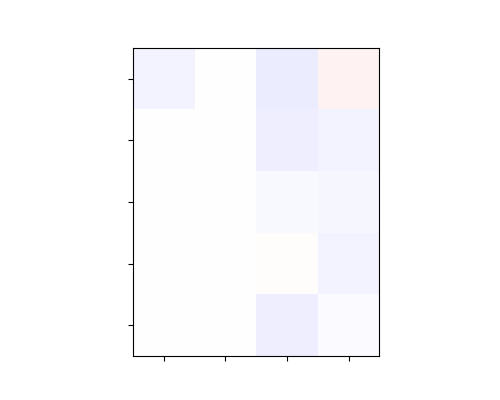

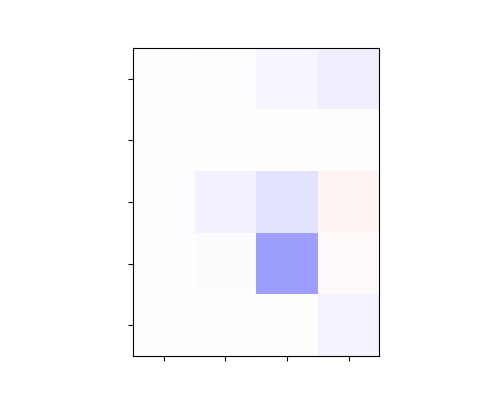

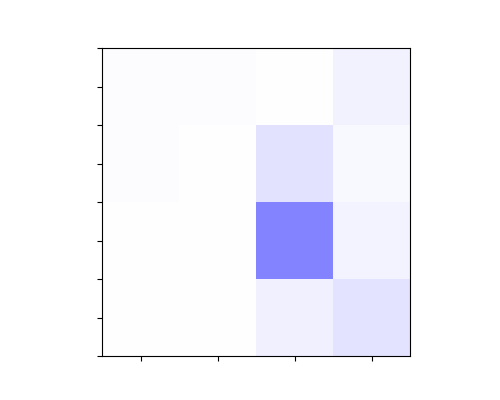

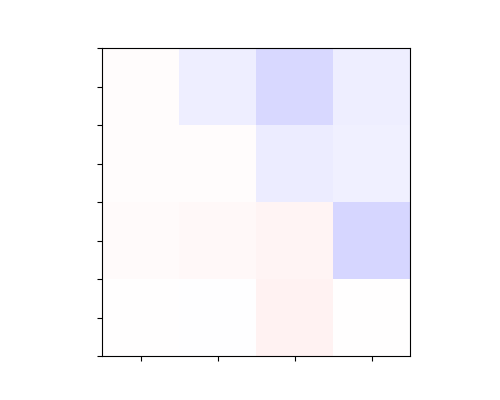

In [72]:
plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(excMaxD-excMax,vmin=-2e-8/scaleFactor,vmax=2e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('../../figures/differenceMatrix_1.png',dpi=600)

plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(excMinD-excMin,vmin=-2e-8/scaleFactor,vmax=2e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('../../figures/differenceMatrix_2.png',dpi=600)


plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(inhMaxD-inhMax,vmin=-2e-8/scaleFactor,vmax=2e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('../../figures/differenceMatrix_3.png',dpi=600)

plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(inhMinD-inhMin,vmin=-2e-8/scaleFactor,vmax=2e-8/scaleFactor,cmap='bwr')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.savefig('../../figures/differenceMatrix_4.png',dpi=600)

### This cell produces the color bar for the figures above

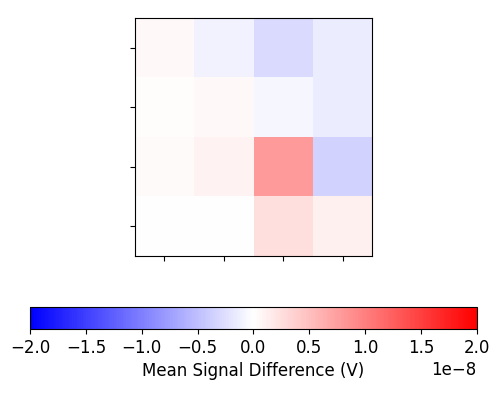

In [98]:
plt.figure(figsize=(5,4))
ax = plt.gca()
plt.imshow(inhMinD-inhMin,vmin=-2e-8/scaleFactor,vmax=2e-8/scaleFactor,cmap='bwr')
plt.colorbar(label = 'Mean Signal Difference (V)', location='bottom')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('../../figures/matrixColorBar_2.png',dpi=600)

# Here, we generate Figure 3a-c. Figure 3d is generated in the 3dAnalysis.ipynb notebook

## This cell plots Fig. 3a.i

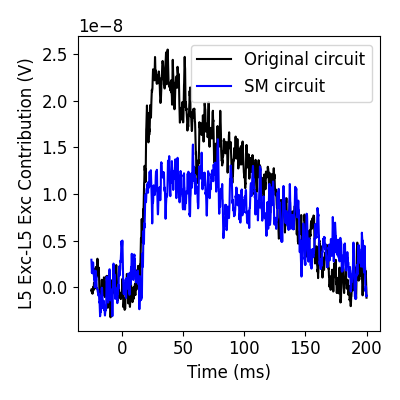

In [138]:
plt.figure(figsize=(4,4))
plt.plot(time, (L5Exc[0,5]+L5Exc[1,5])/scaleFactor,'k')
plt.plot(time, (L5ExcD[0,5]+L5ExcD[1,5])/scaleFactor,'b')
plt.xlabel('Time (ms)')
plt.ylabel('L5 Exc-L5 Exc Contribution (V)')
plt.legend(['Original circuit','SM circuit'])
plt.tight_layout()
plt.savefig('../../figures/L5ExcDifference.png')

## This cell plots Figure 3a.ii

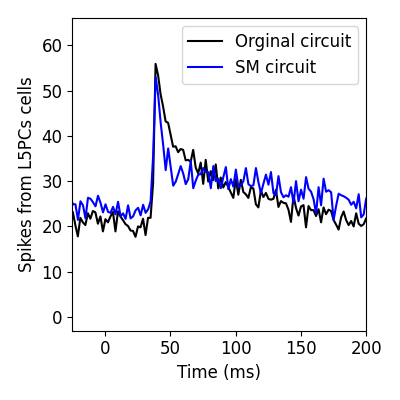

In [152]:
plt.figure(figsize=(4,4))
# bins,spikes = np.histogram(L23Spikes.index,bins=2000)
binsO,spikesO = np.histogram(originalSpikesPC.index,bins=1000)
binsD,spikesD = np.histogram(rewiredSpikesPC.index,bins=1000)

# plt.plot(spikes[1:],bins)
plt.plot(spikesO[1:]-1975,binsO/10,'k')
plt.plot(spikesD[1:]-1975,binsD/9,'b')
# plt.plot(spikes[1:],bins/numRewiredSims)
# plt.plot(spikesO[1:],binsO/10)
plt.xlim([-25,200])
plt.xlabel('Time (ms)')
plt.ylabel('Spikes from L5PCs cells')
plt.legend(['Orginal circuit','SM circuit'])
plt.tight_layout()
plt.savefig('../../figures/spikingPCs.png',dpi=600)

## This cell plots Fig. 3b.i

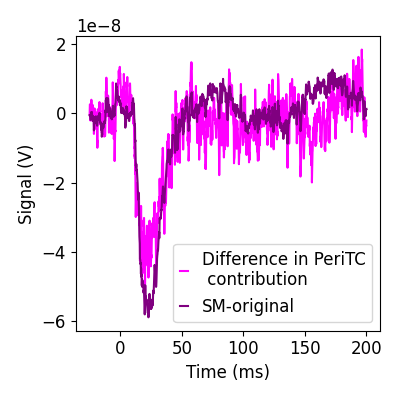

In [139]:
plt.figure(figsize=(4,4))

plt.plot(time,np.sum(contrib_rewired_LBC[0:2]-contrib_LBC[0:2],axis=(0,1))/scaleFactor+np.sum(contrib_rewired_NBC[0:2]-contrib_NBC[0:2],axis=(0,1))/scaleFactor,'magenta')
plt.plot(time,np.sum(mean_layer_rewired[0:2],axis=(0,1))/scaleFactor-np.sum(mean_layer_original[0:2],axis=(0,1))/scaleFactor,'purple')

plt.legend(['Difference in PeriTC\n contribution','SM-original'],handlelength=0.5)

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')
plt.tight_layout()
plt.savefig('../../figures/periTC.png',dpi=600)

## This cell plots Fig. 3b.ii-v

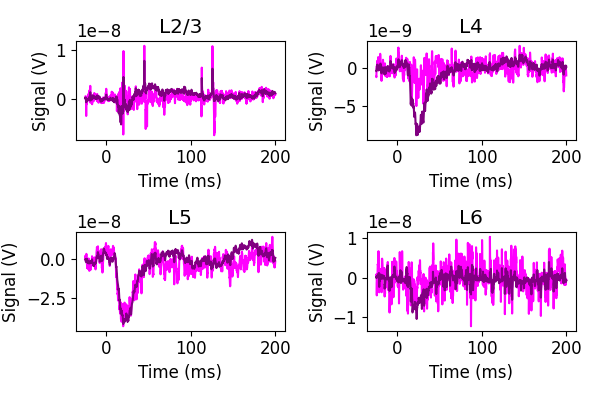

In [256]:
plt.figure(figsize=(6,4))
layers = [2,4,5,6]
for i, layer in enumerate(layers):
    plt.subplot(2,2,i+1)

    if i == 0:
        plt.title('L2/3')
    else:
        plt.title('L'+str(layer))

    plt.plot(time,np.sum(contrib_rewired_LBC[0:2,layer,:]-contrib_LBC[0:2,layer,:]+contrib_rewired_NBC[0:2,layer,:]-contrib_NBC[0:2,layer,:],axis=0)/scaleFactor,'magenta')

    plt.plot(time,np.sum(mean_layer_rewired[0:2,layer,:]-mean_layer_original[0:2,layer,:],axis=0)/scaleFactor,'purple')

    plt.xlabel('Time (ms)')
    plt.ylabel('Signal (au)')

plt.tight_layout()
plt.savefig('../../figures/periTClayer.png',dpi=600)

## This cell plots Figure 3c.i

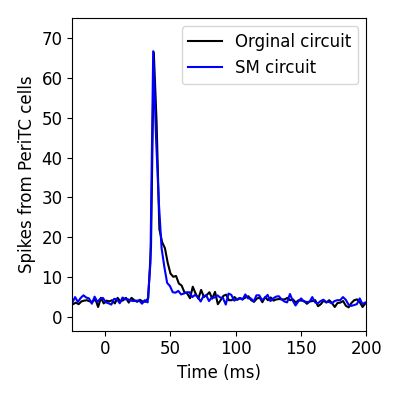

In [158]:
plt.figure(figsize=(4,4))
# bins,spikes = np.histogram(L23Spikes.index,bins=2000)
binsO,spikesO = np.histogram(originalSpikes.index,bins=1000)
binsD,spikesD = np.histogram(rewiredSpikes.index,bins=1000)

# plt.plot(spikes[1:],bins)
plt.plot(spikesO[1:]-1975,binsO/10,'k')
plt.plot(spikesD[1:]-1975,binsD/9,'b')
# plt.plot(spikes[1:],bins/numRewiredSims)
# plt.plot(spikesO[1:],binsO/10)
plt.xlim([-25,200])
plt.xlabel('Time (ms)')
plt.ylabel('Spikes from PeriTC cells')
plt.legend(['Orginal circuit','SM circuit'])
plt.tight_layout()
plt.savefig('../../figures/spiking.png',dpi=600)

## This cell plots Figure 3c.ii

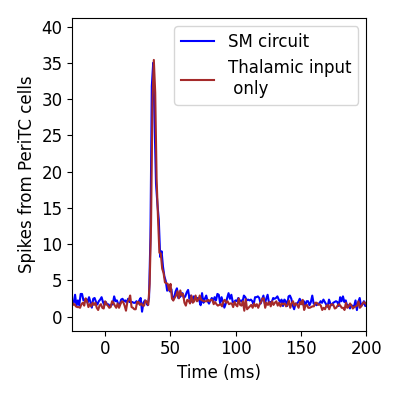

In [160]:
plt.figure(figsize=(4,4))
bins,spikes = np.histogram(rewiredSpikes.index,bins=2000)
binsO,spikesO = np.histogram(disconnectedSpikes.index,bins=2000)
plt.plot(spikes[1:]-1975,bins/9,'b')
plt.plot(spikesO[1:]-1975,binsO/10,'brown')
plt.xlim([-25,200])
plt.xlabel('Time (ms)')
plt.ylabel('Spikes from PeriTC cells')
plt.legend(['SM circuit','Thalamic input\n only'])
plt.tight_layout()
plt.savefig('../../figures/spiking_disconnected.png',dpi=600)

# In the following cells, we generate Figure 4

## The next cell produces Figure 4a

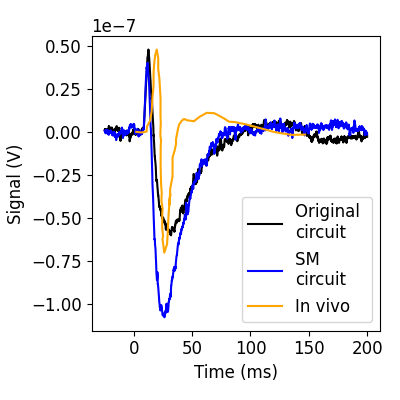

In [131]:
plt.figure(figsize=(4,4))

plt.plot(time,np.sum(mean_layer_original[0]+mean_layer_original[1],axis=0)/scaleFactor,'k',label="Original \ncircuit")
plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor,'b',label="SM \ncircuit")

plt.plot(inVivo[:,0],inVivoY/scaleFactor,'orange',label='In vivo')

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')

handles, labels = plt.gca().get_legend_handles_labels()


order = [0,1,2]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.tight_layout()
plt.savefig('../../figures/ThreeEEG_3.png',dpi=600)

## The next cell produces figure 4b

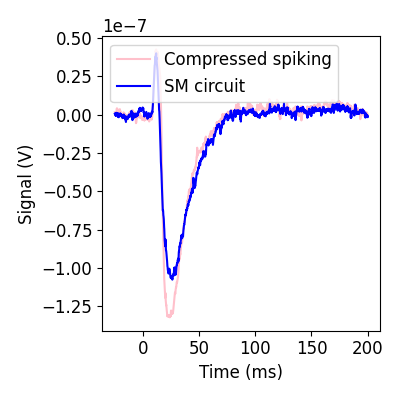

In [132]:
plt.figure(figsize=(4,4))
plt.plot(time,np.sum(mean_layer_compressed[0]+mean_layer_compressed[1],axis=0)/scaleFactor,'pink')
plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor,'b')

plt.legend(['Compressed spiking','SM circuit'])

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')

plt.tight_layout()
plt.savefig('../../figures/compressed.png',dpi=600)

## In the following cells, we calculate the effect of different presynaptic-postsynaptic pathways on the width of the N1 component in the rewired circuit

### This cell calculates $\Delta FWHM$

In [69]:
forig = (FWHM(np.sum(mean_layer_original[0],axis=0))-FWHM(np.sum(mean_layer_rewired[0],axis=0)))

### This cell calculates $\Delta_{x\rightarrow y}$ for all inhibitory presynaptic populations

In [66]:
l2minus5 = FWHM(np.sum(mean_layer_L23Inh[0:2], axis=(0, 1)) + np.sum(L23Inh[0:2, [2,4,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L23InhD[0:2], axis=(0, 1)) + np.sum(L23InhD[0:2, [2,4,6]], axis=(0, 1))))

l2minus6 = FWHM(np.sum(mean_layer_L23Inh[0:2], axis=(0, 1)) + np.sum(L23Inh[0:2, [2,4,5]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L23InhD[0:2], axis=(0, 1)) + np.sum(L23InhD[0:2, [2,4,5]], axis=(0, 1))))

l2minus2 = FWHM(np.sum(mean_layer_L23Inh[0:2], axis=(0, 1)) + np.sum(L23Inh[0:2, [4,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L23InhD[0:2], axis=(0, 1)) + np.sum(L23InhD[0:2, [4,5,6]], axis=(0, 1))))

l2minus4 = FWHM(np.sum(mean_layer_L23Inh[0:2], axis=(0, 1)) + np.sum(L23Inh[0:2, [2,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L23InhD[0:2], axis=(0, 1)) + np.sum(L23InhD[0:2, [2,5,6]], axis=(0, 1))))

l4minus5 = FWHM(np.sum(mean_layer_L4[0:2], axis=(0, 1)) + np.sum(L4Inh[0:2, [2,4,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L4InhD[0:2], axis=(0, 1)) + np.sum(L4InhD[0:2, [2,4,6]], axis=(0, 1))))

l4minus6 = FWHM(np.sum(mean_layer_L4[0:2], axis=(0, 1)) + np.sum(L4Inh[0:2, [2,4,5]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L4InhD[0:2], axis=(0, 1)) + np.sum(L4InhD[0:2, [2,4,5]], axis=(0, 1))))

l4minus2 = FWHM(np.sum(mean_layer_L4[0:2], axis=(0, 1)) + np.sum(L4Inh[0:2, [4,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L4InhD[0:2], axis=(0, 1)) + np.sum(L4InhD[0:2, [4,5,6]], axis=(0, 1))))

l4minus4 = FWHM(np.sum(mean_layer_L4[0:2], axis=(0, 1)) + np.sum(L4Inh[0:2, [2,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L4InhD[0:2], axis=(0, 1)) + np.sum(L4InhD[0:2, [2,5,6]], axis=(0, 1))))

l5minus2 = FWHM(np.sum(mean_layer_L5[0:2], axis=(0, 1)) + np.sum(L5Inh[0:2, [4,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L5InhD[0:2], axis=(0, 1)) + np.sum(L5InhD[0:2, [4,5,6]], axis=(0, 1))))

l5minus4 = FWHM(np.sum(mean_layer_L5[0:2], axis=(0, 1)) + np.sum(L5Inh[0:2, [2,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L5InhD[0:2], axis=(0, 1)) + np.sum(L5InhD[0:2, [2,5,6]], axis=(0, 1))))

l5minus5 = FWHM(np.sum(mean_layer_L5[0:2], axis=(0, 1)) + np.sum(L5Inh[0:2, [2,4,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L5InhD[0:2], axis=(0, 1)) + np.sum(L5InhD[0:2, [2,4,6]], axis=(0, 1))))

l5minus6 = FWHM(np.sum(mean_layer_L5[0:2], axis=(0, 1)) + np.sum(L5Inh[0:2, [2,4,5]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L5InhD[0:2], axis=(0, 1)) + np.sum(L5InhD[0:2, [2,4,5]], axis=(0, 1))))

l6minus5 = FWHM(np.sum(mean_layer_L6[0:2], axis=(0, 1)) + np.sum(L6Inh[0:2, [2,4,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L6InhD[0:2], axis=(0, 1)) + np.sum(L6InhD[0:2, [2,4,6]], axis=(0, 1))))

l6minus6 = FWHM(np.sum(mean_layer_L6[0:2], axis=(0, 1)) + np.sum(L6Inh[0:2, [2,4,5]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L6InhD[0:2], axis=(0, 1)) + np.sum(L6InhD[0:2, [2,4,5]], axis=(0, 1))))

l6minus2 = FWHM(np.sum(mean_layer_L6[0:2], axis=(0, 1)) + np.sum(L6Inh[0:2, [4,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L6InhD[0:2], axis=(0, 1)) + np.sum(L6InhD[0:2, [4,5,6]], axis=(0, 1))))

l6minus4 = FWHM(np.sum(mean_layer_L6[0:2], axis=(0, 1)) + np.sum(L6Inh[0:2, [2,5,6]], axis=(0, 1))) - \
           (FWHM(np.sum(mean_layer_L6InhD[0:2], axis=(0, 1)) + np.sum(L6InhD[0:2, [2,5,6]], axis=(0, 1))))

inhibitoryf = np.array([[l2minus2, l2minus4,l2minus5,l2minus6],[l4minus2, l4minus4,l4minus5,l4minus6],[l5minus2, l5minus4,l5minus5,l5minus6],[l6minus2, l6minus4,l6minus5,l6minus6]])


### This cell calculates $\Delta_{x\rightarrow y}$ for all excitatory presynaptic populations

In [67]:
tminus5 = FWHM(np.sum(mean_layer_disconnected_noThal[0:2], axis=(0, 1)) + np.sum(contrib_thal[0:2, [2,4,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_disconnected_noThalR[0:2], axis=(0, 1)) + np.sum(contrib_thalR[0:2, [2,4,6]], axis=(0, 1))))

tminus6 = FWHM(np.sum(mean_layer_disconnected_noThal[0:2], axis=(0, 1)) + np.sum(contrib_thal[0:2, [2,4,5]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_disconnected_noThalR[0:2], axis=(0, 1)) + np.sum(contrib_thalR[0:2, [2,4,5]], axis=(0, 1))))

tminus2 = FWHM(np.sum(mean_layer_disconnected_noThal[0:2], axis=(0, 1)) + np.sum(contrib_thal[0:2, [4,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_disconnected_noThalR[0:2], axis=(0, 1)) + np.sum(contrib_thalR[0:2, [4,5,6]], axis=(0, 1))))

tminus4 = FWHM(np.sum(mean_layer_disconnected_noThal[0:2], axis=(0, 1)) + np.sum(contrib_thal[0:2, [2,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_disconnected_noThalR[0:2], axis=(0, 1)) + np.sum(contrib_thalR[0:2, [2,5,6]], axis=(0, 1))))

tminus5 = FWHM(np.sum(mean_layer_disconnected_noThal[0:2], axis=(0, 1)) + np.sum(contrib_thal[0:2, [2,4,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_disconnected_noThalR[0:2], axis=(0, 1)) + np.sum(contrib_thalR[0:2, [2,4,6]], axis=(0, 1))))


l2minus5 = FWHM(np.sum(mean_layer_L23Exc[0:2], axis=(0, 1)) + np.sum(L23Exc[0:2, [2,4,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L23ExcD[0:2], axis=(0, 1)) + np.sum(L23ExcD[0:2, [2,4,6]], axis=(0, 1))))

l2minus6 = FWHM(np.sum(mean_layer_L23Exc[0:2], axis=(0, 1)) + np.sum(L23Exc[0:2, [2,4,5]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L23ExcD[0:2], axis=(0, 1)) + np.sum(L23ExcD[0:2, [2,4,5]], axis=(0, 1))))

l2minus2 = FWHM(np.sum(mean_layer_L23Exc[0:2], axis=(0, 1)) + np.sum(L23Exc[0:2, [4,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L23ExcD[0:2], axis=(0, 1)) + np.sum(L23ExcD[0:2, [4,5,6]], axis=(0, 1))))

l2minus4 = FWHM(np.sum(mean_layer_L23Exc[0:2], axis=(0, 1)) + np.sum(L23Exc[0:2, [2,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L23ExcD[0:2], axis=(0, 1)) + np.sum(L23ExcD[0:2, [2,5,6]], axis=(0, 1))))

l4minus5 = FWHM(np.sum(mean_layer_L4Exc[0:2], axis=(0, 1)) + np.sum(L4Exc[0:2, [2,4,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L4ExcD[0:2], axis=(0, 1)) + np.sum(L4ExcD[0:2, [2,4,6]], axis=(0, 1))))

l4minus6 = FWHM(np.sum(mean_layer_L4Exc[0:2], axis=(0, 1)) + np.sum(L4Exc[0:2, [2,4,5]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L4ExcD[0:2], axis=(0, 1)) + np.sum(L4ExcD[0:2, [2,4,5]], axis=(0, 1))))

l4minus2 = FWHM(np.sum(mean_layer_L4Exc[0:2], axis=(0, 1)) + np.sum(L4Exc[0:2, [4,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L4ExcD[0:2], axis=(0, 1)) + np.sum(L4ExcD[0:2, [4,5,6]], axis=(0, 1))))

l4minus4 = FWHM(np.sum(mean_layer_L4Exc[0:2], axis=(0, 1)) + np.sum(L4Exc[0:2, [2,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L4ExcD[0:2], axis=(0, 1)) + np.sum(L4ExcD[0:2, [2,5,6]], axis=(0, 1))))

l5minus2 = FWHM(np.sum(mean_layer_L5Exc[0:2], axis=(0, 1)) + np.sum(L5Exc[0:2, [4,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L5ExcD[0:2], axis=(0, 1)) + np.sum(L5ExcD[0:2, [4,5,6]], axis=(0, 1))))

l5minus4 = FWHM(np.sum(mean_layer_L5Exc[0:2], axis=(0, 1)) + np.sum(L5Exc[0:2, [2,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L5ExcD[0:2], axis=(0, 1)) + np.sum(L5ExcD[0:2, [2,5,6]], axis=(0, 1))))

l5minus5 = FWHM(np.sum(mean_layer_L5Exc[0:2], axis=(0, 1)) + np.sum(L5Exc[0:2, [2,4,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L5ExcD[0:2], axis=(0, 1)) + np.sum(L5ExcD[0:2, [2,4,6]], axis=(0, 1))))

l5minus6 = FWHM(np.sum(mean_layer_L5Exc[0:2], axis=(0, 1)) + np.sum(L5Exc[0:2, [2,4,5]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L5ExcD[0:2], axis=(0, 1)) + np.sum(L5ExcD[0:2, [2,4,5]], axis=(0, 1))))

l6minus5 = FWHM(np.sum(mean_layer_L6Exc[0:2], axis=(0, 1)) + np.sum(L6Exc[0:2, [2,4,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L6ExcD[0:2], axis=(0, 1)) + np.sum(L6ExcD[0:2, [2,4,6]], axis=(0, 1))))

l6minus6 = FWHM(np.sum(mean_layer_L6Exc[0:2], axis=(0, 1)) + np.sum(L6Exc[0:2, [2,4,5]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L6ExcD[0:2], axis=(0, 1)) + np.sum(L6ExcD[0:2, [2,4,5]], axis=(0, 1))))

l6minus2 = FWHM(np.sum(mean_layer_L6Exc[0:2], axis=(0, 1)) + np.sum(L6Exc[0:2, [4,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L6ExcD[0:2], axis=(0, 1)) + np.sum(L6ExcD[0:2, [4,5,6]], axis=(0, 1))))

l6minus4 = FWHM(np.sum(mean_layer_L6Exc[0:2], axis=(0, 1)) + np.sum(L6Exc[0:2, [2,5,6]], axis=(0, 1))) - \
          (FWHM(np.sum(mean_layer_L6ExcD[0:2], axis=(0, 1)) + np.sum(L6ExcD[0:2, [2,5,6]], axis=(0, 1))))

excitatoryf = np.array([[tminus2, tminus4,tminus5,tminus6],[l2minus2, l2minus4,l2minus5,l2minus6],[l4minus2, l4minus4,l4minus5,l4minus6],[l5minus2, l5minus4,l5minus5,l5minus6],[l6minus2, l6minus4,l6minus5,l6minus6]])


### This cell plots Fig. 4c.i

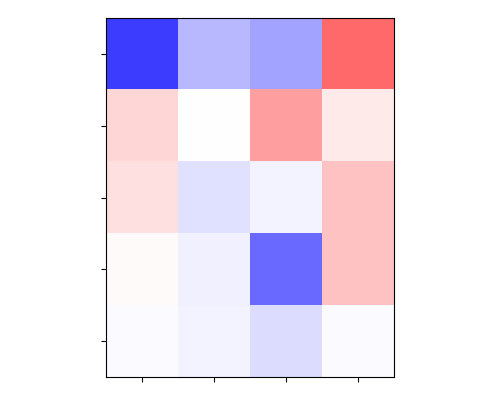

In [71]:
plt.figure(figsize=(5,4))
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(forig-excitatoryf,vmin=-5,vmax=5,cmap='bwr')
plt.tight_layout()
plt.savefig('../../figures/fwhmexc.png',dpi=600)

### This cell plots Figure 4c.ii

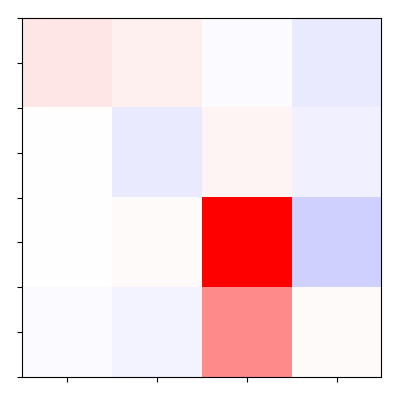

In [70]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(forig-inhibitoryf,vmin=-5,vmax=5,cmap='bwr')
plt.tight_layout()

plt.savefig('../../figures/fwhminh.png',dpi=600)

### This cell plots the color bar for the previous panels

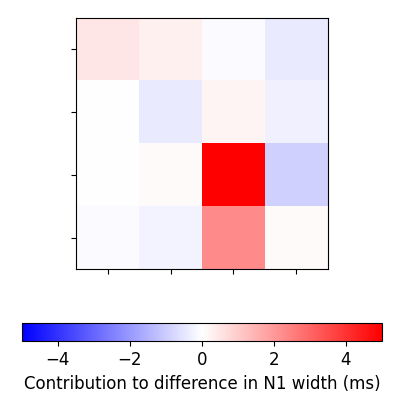

In [436]:

plt.figure(figsize=(4,4))
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(forig-inhibitoryf,vmin=-5,vmax=5,cmap='bwr')
plt.tight_layout()

plt.colorbar(label = 'Contribution to difference in N1 width (ms)', location='bottom')

plt.savefig('../../figures/fwhmcolorbar.png',dpi=600)


#### This cell plots Fig. 4d.i

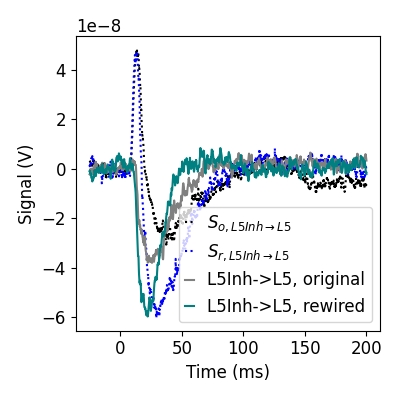

In [112]:
plt.figure(figsize=(4,4))
plt.plot(time,np.sum(mean_layer_original[0]+mean_layer_original[1],axis=0)/scaleFactor-(L5Inh[0,5]+L5Inh[1,5])/scaleFactor,':k')
plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor-(L5InhD[0,5]+L5InhD[1,5])/scaleFactor,':b')
plt.plot(time,(L5Inh[0,5]+L5Inh[1,5])/scaleFactor,'grey')
plt.plot(time,(L5InhD[0,5]+L5InhD[1,5])/scaleFactor,'teal')


plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')
plt.legend([r'$S_{o,L5Inh \rightarrow L5}$',r'$S_{r,L5Inh \rightarrow L5}$','L5Inh->L5, original','L5Inh->L5, rewired'],loc='lower right',handlelength=0.5)
plt.tight_layout()
plt.savefig('../../figures/fwhml5signal.png',dpi=600)

### This cell plots Figure 4d.ii

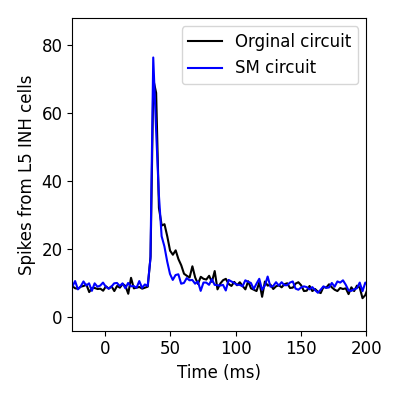

In [153]:
plt.figure(figsize=(4,4))
# bins,spikes = np.histogram(L23Spikes.index,bins=2000)
binsO,spikesO = np.histogram(originalSpikesInh5.index,bins=1000)
binsD,spikesD = np.histogram(rewiredSpikesInh5.index,bins=1000)

plt.plot(spikesO[1:]-1975,binsO/10,'k')
plt.plot(spikesD[1:]-1975,binsD/9,'b')

plt.xlim([-25,200])
plt.xlabel('Time (ms)')
plt.ylabel('Spikes from L5 INH cells')
plt.legend(['Orginal circuit','SM circuit'])
plt.tight_layout()
plt.savefig('../../figures/spikingInh5s.png',dpi=600)

### This cell plots Fig. 4e.i

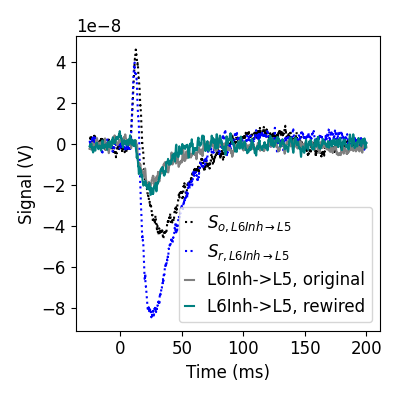

In [113]:
plt.figure(figsize=(4,4))
plt.plot(time,np.sum(mean_layer_original[0]+mean_layer_original[1],axis=0)/scaleFactor-(L6Inh[0,5]+L6Inh[1,5])/scaleFactor,':k')
plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor-(L6InhD[0,5]+L6Inh[1,5])/scaleFactor,':b')
plt.plot(time,L6Inh[0,5]/scaleFactor+L6Inh[1,5]/scaleFactor,'grey')
plt.plot(time,L6InhD[0,5]/scaleFactor+L6InhD[1,5]/scaleFactor,'teal')

plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')
plt.legend([r'$S_{o,L6Inh \rightarrow L5}$',r'$S_{r,L6Inh \rightarrow L5}$','L6Inh->L5, original','L6Inh->L5, rewired'],loc='lower right',handlelength=0.5)
plt.tight_layout()
plt.savefig('../../figures/fwhml6signal.png',dpi=600)

### This cell plots Figure 4e.ii

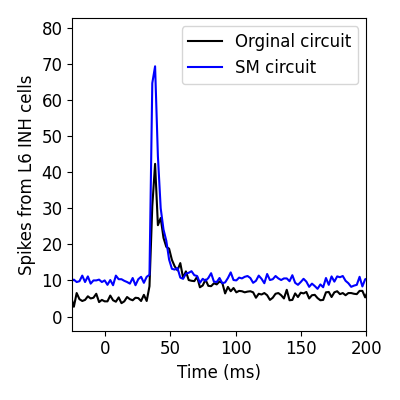

In [154]:
plt.figure(figsize=(4,4))
binsO,spikesO = np.histogram(originalSpikesInh6.index,bins=1000)
binsD,spikesD = np.histogram(rewiredSpikesInh6.index,bins=1000)

# plt.plot(spikes[1:],bins)
plt.plot(spikesO[1:]-1975,binsO/10,'k')
plt.plot(spikesD[1:]-1975,binsD/9,'b')

plt.xlim([-25,200])
plt.xlabel('Time (ms)')
plt.ylabel('Spikes from L6 INH cells')
plt.legend(['Orginal circuit','SM circuit'])
plt.tight_layout()
plt.savefig('../../figures/spikingInh6s.png',dpi=600)

### This cell plots Fig. 4f.i

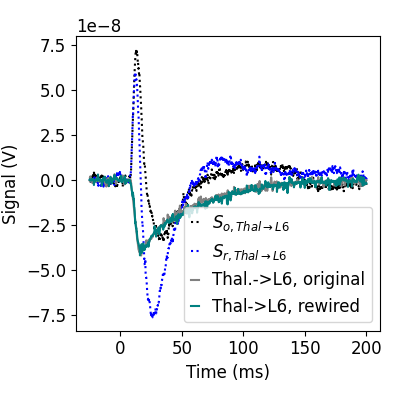

In [114]:
plt.figure(figsize=(4,4))

plt.plot(time,np.sum(mean_layer_original[0]+mean_layer_original[1],axis=0)/scaleFactor-(L23Exc[0,5]+L23Exc[1,5])/scaleFactor,':k')
plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor-(L23ExcD[0,5]+L23ExcD[1,5])/scaleFactor,':b')
plt.plot(time,L23Exc[0,5]/scaleFactor+L23Exc[1,5]/scaleFactor,'grey')
plt.plot(time,L23ExcD[0,5]/scaleFactor+L23ExcD[1,5]/scaleFactor,'teal')


plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')
plt.legend([r'$S_{o,L2/3 EXC\rightarrow L5}$',r'$S_{r,L2/3 EXC \rightarrow L5}$','L2/3 EXC->L5, original','L2/3 EXC->L5, rewired'],loc='lower right',handlelength=0.5)
plt.tight_layout()
plt.savefig('../../figures/fwhml2signal.png',dpi=600)

### This cell plots Fig. 4f.ii

In [ ]:
plt.figure(figsize=(4,4))
binsO,spikesO = np.histogram(originalSpikes23PC.index,bins=1000)
binsD,spikesD = np.histogram(rewiredSpikes23PC.index,bins=1000)

# plt.plot(spikes[1:],bins)
plt.plot(spikesO[1:]-1975,binsO/10,'k')
plt.plot(spikesD[1:]-1975,binsD/9,'b')

plt.xlim([-25,200])
plt.xlabel('Time (ms)')
plt.ylabel('Spikes from L6 INH cells')
plt.legend(['Orginal circuit','SM circuit'])
plt.tight_layout()
plt.savefig('../../figures/spiking23PCs.png',dpi=600)

# Here, we generate the supplementary Figures

## This cell produces Supplementary Figure S1a

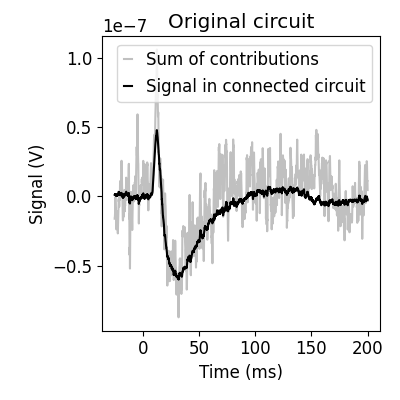

In [164]:
plt.figure(figsize=(4,4))

inhTotal = np.sum(L1InhD[0],axis=0)+np.sum(L23Inh[0],axis=0)+np.sum(L4Inh[0],axis=0)+np.sum(L5Inh[0],axis=0)+np.sum(L6Inh[0],axis=0)
inhTotal += np.sum(L1InhD[1],axis=0)+np.sum(L23Inh[1],axis=0)+np.sum(L4Inh[1],axis=0)+np.sum(L5Inh[1],axis=0)+np.sum(L6Inh[1],axis=0)
excTotal = np.sum(L23Exc[0],axis=0)+np.sum(L4Exc[0],axis=0)+np.sum(L5Exc[0],axis=0)+np.sum(L6Exc[0],axis=0)
excTotal += np.sum(L23Exc[1],axis=0)+np.sum(L4Exc[1],axis=0)+np.sum(L5Exc[1],axis=0)+np.sum(L6Exc[1],axis=0)


t = np.sum(contrib_thal[0]+contrib_thal[1],axis=0)+inhTotal+excTotal

plt.plot(time,t/scaleFactor,'silver')
plt.plot(time,np.sum(mean_layer_original[0]+mean_layer_original[1],axis=0)/scaleFactor,'k')
plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')
plt.legend(['Sum of contributions','Signal in connected circuit'],handlelength=0.5)
plt.tight_layout()
plt.title('Original circuit')
plt.savefig('../../figures/sumOfContributions.png',dpi=600)


## This cell produces Supplementary Figure S1b

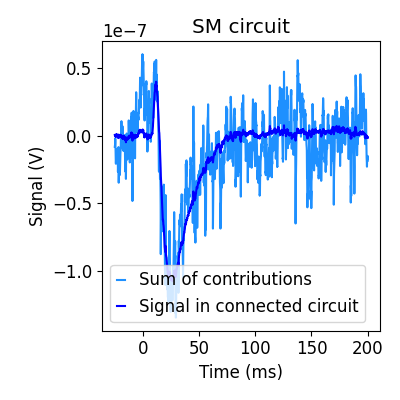

In [166]:
plt.figure(figsize=(4,4))

inhTotal = np.sum(L1InhD[0],axis=0)+np.sum(L23InhD[0],axis=0)+np.sum(L4InhD[0],axis=0)+np.sum(L5InhD[0],axis=0)+np.sum(L6InhD[0],axis=0)
inhTotal += np.sum(L23InhD[1],axis=0)+np.sum(L4InhD[1],axis=0)+np.sum(L5InhD[1],axis=0)+np.sum(L6InhD[1],axis=0)

excTotal = np.sum(L23ExcD[0],axis=0)+np.sum(L4ExcD[0],axis=0)+np.sum(L5ExcD[0],axis=0)+np.sum(L6ExcD[0],axis=0)
excTotal += np.sum(L23ExcD[1],axis=0)+np.sum(L4ExcD[1],axis=0)+np.sum(L5ExcD[1],axis=0)+np.sum(L6ExcD[1],axis=0)


plt.plot(time,(np.sum(contrib_thalR[0]+contrib_thalR[1],axis=0)+inhTotal+excTotal)/scaleFactor,'dodgerblue')

plt.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor,'b')
plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')
plt.legend(['Sum of contributions','Signal in connected circuit'],handlelength=0.5)
plt.title('SM circuit')
plt.tight_layout()
plt.savefig('../../figures/sumOfContributions_rewired.png',dpi=600)


## The next cell produces Supplementary figure S2

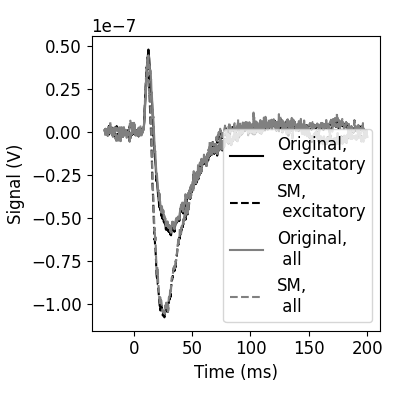

In [167]:
plt.figure(figsize=(4,4))
plt.plot(time,np.sum(mean_layer_original[0],axis=0)/scaleFactor,'k')
plt.plot(time,np.sum(mean_layer_rewired[0],axis=0)/scaleFactor,'--k')

plt.plot(time,np.sum(mean_layer_original[0],axis=0)/scaleFactor+np.sum(mean_layer_original[1],axis=0)/scaleFactor,'grey')
plt.plot(time,np.sum(mean_layer_rewired[0],axis=0)/scaleFactor+np.sum(mean_layer_rewired[1],axis=0)/scaleFactor,'--',c='grey')


plt.xlabel('Time (ms)')
plt.ylabel('Signal (au)')

plt.legend(['Original,\n excitatory','SM,\n excitatory','Original,\n all','SM,\n all'])

plt.tight_layout()
plt.savefig('../../figures/sumInhExc.png',dpi=600)

## The next cell produces Supplementary figure S3

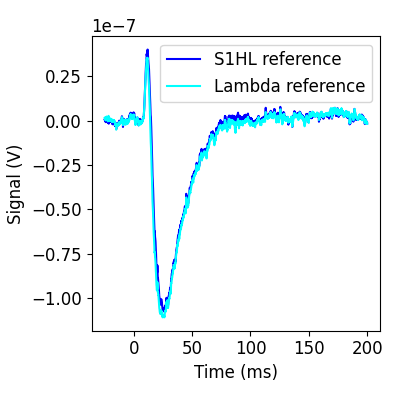

In [80]:
fig, ax = plt.subplots(figsize=(4,4))
ax2 = ax.twinx()

ax.plot(time,np.sum(mean_layer_rewired[0]+mean_layer_rewired[1],axis=0)/scaleFactor,'b')
ax2.plot(time,np.sum(mean_layer_rewired_reference[0]+mean_layer_rewired_reference[1],axis=0)/scaleFactor,'cyan')


ax.set_xlabel('Time (ms)')
ax.set_ylabel('S1HL Signal (au)')
ax2.set_ylabel('Lambda Signal (au)')

plt.tight_layout()
plt.savefig('../../figures/reference.png',dpi=600)